# Health Prediction using Fully Homomorphic Encryption

Processing medical data has long posed a significant challenge in the realm of machine learning primarily due to the sensitive nature of the data and the rigorous regulations safeguarding patient privacy.

This notebook showcases the use of Concrete ML for a diagnosis task that relies on sensitive information: patient symptoms. Additionally, the notebook provides guidance on how to select the most appropriate Concrete model for real-life deployment in this [Hugging Face space](https://huggingface.co/spaces/zama-fhe/health_prediction).

### Import libraries

In [1]:
import shutil
from pathlib import Path
from time import time
from typing import Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from preprocessing import prepare_data
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

### Data-set


The data used are available via this [link](https://github.com/anujdutt9/Disease-Prediction-from-Symptoms/tree/master/dataset).


For the sake of simplicity, we performed a preliminary preprocessing on the data, such as correcting column names and encoding the target column that we saved in [Training_preprocessed.csv](./data/Training_preprocessed.csv) for the training set and [Testing_preprocessed.csv](./data/Testing_preprocessed.csv) for test set.

In [2]:
# Load the train and testing sets

df_train, df_test = prepare_data()

TARGET_COLUMN = ["prognosis_encoded", "prognosis"]

y_train = df_train[TARGET_COLUMN[0]].values.flatten()
y_test = df_test[TARGET_COLUMN[0]].values.flatten()

X_train = df_train.drop(TARGET_COLUMN, axis=1)
X_test = df_test.drop(TARGET_COLUMN, axis=1)

df_train.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurving,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,prognosis_encoded
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fungal Infection,14


In [3]:
print(
    f"The dataset contains: {X_train.shape[1]} distinct symptoms and "
    f"{len(np.unique(y_train))} unique diseases."
)

The dataset contains: 128 distinct symptoms and 41 unique diseases.


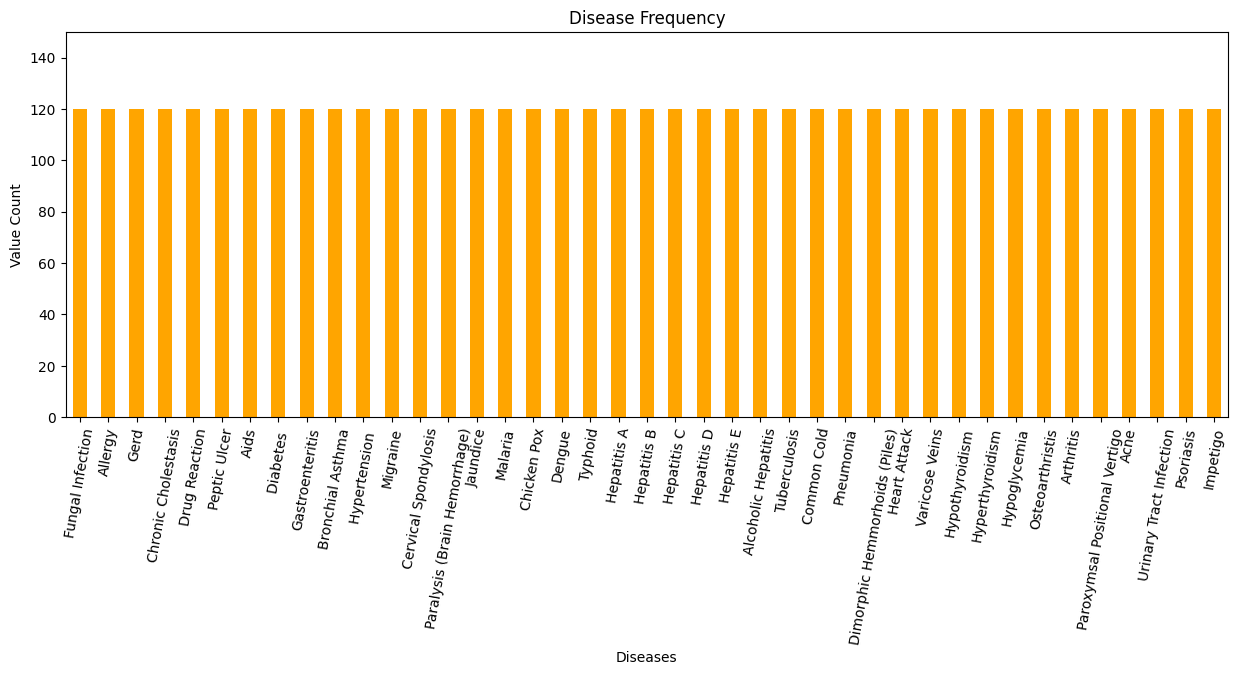

In [4]:
# The Training data-set is well-balanced

value_counts = df_train[TARGET_COLUMN[1]].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 5))

ax = value_counts.plot.bar(color="orange")
ax.set_xlabel("Diseases")
ax.set_ylim(0, 150)
ax.set_ylabel("Value Count")
ax.set_title("Disease Frequency")

plt.xticks(rotation=80)
plt.show()

## Accuracy vs speed trade-off for FHE ML models

FHE programs are slower due to various factors, including the high cost of PBS operations and current hardware limitations. However, ongoing research is actively improving the performance of FHE to overcome these constraints. To mitigate these constraints in real-life use-cases, developers must search for an optimal model configuration that obtains an interesting trade-off between speed and accuracy. To do so, we use grid search, evaluating the model using FHE simulation mode.

In [5]:
def grid_search(grid_param: Dict, clf: Callable) -> GridSearchCV:
    """
    Perform a grid search to find the best hyper-parameters for a given classifier.

    Args:
        grid_param (Dict): The hyper-parameters to be tuned
        clf (Callable): The given classifier

    Returns:
        GridSearchCV: The fitted GridSearchCV object.

    """
    grid_search = GridSearchCV(
        clf,
        grid_param,
        cv=4,
        verbose=1,
        n_jobs=-1,
    ).fit(X_train, y_train)

    # The best model
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.2%}")

    return grid_search

In [6]:
def fhe_evaluation(
    grid_search: GridSearchCV, clf_class: Callable, grid_param: Dict, X_test: np.ndarray
) -> pd.DataFrame:
    """
    Mesuare the time inference in FHE for each possible combinaison.

    Args:
        grid_search (GridSearchCV): Grid search object used to find the best hyperparameters
        clf_class (Callable): The classifier model to be evaluated
        grid_param (Dict): The hyper-parameters associated to the givin classifier
        X_test (np.ndarray): One sample used to measure the time inference in FHE

    Returns:
        pd.DataFrame: All combinaison of hyper-parameters and their mean test scores, standard test
            scores, and time inference in FHE

    """
    # Save the grid search results as a DataFrame
    grid_results = pd.DataFrame(grid_search.cv_results_)
    grid_results.columns = grid_results.columns.str.replace("param_", "")
    # Pick up relevent columns
    grid_results = grid_results[list(grid_param.keys()) + ["mean_test_score", "std_test_score"]]
    # Sort the results by mean_test_score in descending order
    grid_results = grid_results.sort_values(by="mean_test_score", ascending=False)

    fhe_inference_time = []
    for _, param in tqdm(grid_results[list(grid_param.keys())].iterrows()):
        # Instanciation
        clf = clf_class(**dict(param))
        # Training
        clf.fit(X_train, y_train)
        fhe_circuit = clf.compile(X_train)
        # Key generation
        fhe_circuit.client.keygen(force=False)
        # Inference
        start_time = time()
        _ = clf.predict(X_test, fhe="execute")
        fhe_inference_time.append(time() - start_time)
    grid_results["fhe_inference_time"] = fhe_inference_time

    return grid_results

We start with XGB classifier:

In [7]:
grid_xgb_param = {
    "n_bits": [2, 3, 4, 5, 6, 7],
    "max_depth": [1, 2, 3],
    "n_estimators": [2, 3],
}

gr_xgb = grid_search(grid_xgb_param, ConcreteXGBClassifier())

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best parameters: {'max_depth': 3, 'n_bits': 7, 'n_estimators': 2}
Best score: 99.88%


Then, we test the Logistic Regression model:

In [8]:
grid_logit_param = {
    "C": [0.001, 0.5, 0.9, 1.0],
    "n_bits": [7, 10, 13, 14],
    "solver": ["newton-cg", "sag", "saga", "lbfgs"],
    "multi_class": ["auto"],
}

gs_logit = grid_search(grid_logit_param, ConcreteLogisticRegression())

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters: {'C': 0.5, 'multi_class': 'auto', 'n_bits': 7, 'solver': 'newton-cg'}
Best score: 100.00%


The best model configuration may not necessarily mean the best performing model in the FHE realm. To highlight this nuance, we measure the inference timing for a single random sample in real FHE mode for each configuration.

In [9]:
# Take a random input as a test case to measure the execution time of all the Concrete ML models
random_row = df_test.sample().values[0]

random_x, random_y = random_row[:-2][np.newaxis, :], random_row[-2]

print(f"Random disease: {random_y}")

Random disease: Migraine


In [10]:
xgb_results = fhe_evaluation(gr_xgb, ConcreteXGBClassifier, grid_xgb_param, random_x)

0it [00:00, ?it/s]

In [11]:
logit_results = fhe_evaluation(gs_logit, ConcreteLogisticRegression, grid_logit_param, random_x)

0it [00:00, ?it/s]

For each Concrete ML model, we display its score along with the corresponding inference timing.
This enables us to evaluate the model's effectiveness in terms of performance and its computational efficiency.

In [12]:
# XGB

index = 2
xgb_results.style.background_gradient(
    subset=["n_bits", "mean_test_score", "fhe_inference_time"]
).apply(
    lambda index: ["background-color: green"] * len(index), axis=1, subset=pd.IndexSlice[[index], :]
)

,n_bits,max_depth,n_estimators,mean_test_score,std_test_score,fhe_inference_time
34,7,3,2,0.998780,0.001220,50.848390
35,7,3,3,0.997561,0.002439,77.306330
33,6,3,3,0.995122,0.004878,29.819495
32,6,3,2,0.995122,0.004878,18.353732
23,7,2,3,0.992683,0.007317,57.148737
22,7,2,2,0.992683,0.007317,38.101938
21,6,2,3,0.990244,0.009756,21.930150
20,6,2,2,0.990244,0.009756,14.774465
31,5,3,3,0.984146,0.015854,11.284927
30,5,3,2,0.984146,0.015854,6.420574


In [13]:
# Logit

index = 42
logit_results.style.background_gradient(
    subset=["n_bits", "mean_test_score", "fhe_inference_time"]
).apply(
    lambda index: ["background-color: green"] * len(index), axis=1, subset=pd.IndexSlice[[index], :]
)

,C,n_bits,solver,multi_class,mean_test_score,std_test_score,fhe_inference_time
32,0.900000,7,newton-cg,auto,1.000000,0.000000,0.005855
48,1.000000,7,newton-cg,auto,1.000000,0.000000,0.006321
35,0.900000,7,lbfgs,auto,1.000000,0.000000,0.007907
36,0.900000,10,newton-cg,auto,1.000000,0.000000,0.012095
37,0.900000,10,sag,auto,1.000000,0.000000,0.008803
38,0.900000,10,saga,auto,1.000000,0.000000,0.009139
39,0.900000,10,lbfgs,auto,1.000000,0.000000,0.008595
40,0.900000,13,newton-cg,auto,1.000000,0.000000,0.008255
41,0.900000,13,sag,auto,1.000000,0.000000,0.008248
42,0.900000,13,saga,auto,1.000000,0.000000,0.007975


In real-time applications, inference time is a crucial factor.

From XGB's results, we can see that most accurate models are also the ones that have the longest inference times in FHE. However, considering less complex configurations could can offer a viable compromise between efficiency and accuracy.

In this specific use case, Logistic Regression outperforms XGB in terms of both accuracy and time computing.

### Most optimal model in FHE 

In [14]:
# The most optimal model in the FHE realm is:

optimal_param = {"C": 0.9, "n_bits": 13, "solver": "sag", "multi_class": "auto"}

clf = ConcreteLogisticRegression(**optimal_param)

clf.fit(X_train, y_train)

fhe_circuit = clf.compile(X_train)

fhe_circuit.client.keygen(force=False)

In [15]:
# Simulated FHE mode

start_time = time()
y_pred = clf.predict(random_x, fhe="simulate")

print(
    f"Inference timing: {time() - start_time:.3f} s"
    f"Prediction: {y_pred[0]} -> "
    f"{df_test[df_test['prognosis_encoded'] == y_pred[0]]['prognosis'].values[0]}"
)

Inference timing: 0.003 sPrediction: 30 -> Migraine


In [16]:
# FHE mode

start_time = time()
y_pred = clf.predict(random_x, fhe="execute")

print(
    f"Inference timing: {time() - start_time:.3f} s"
    f"Prediction: {y_pred[0]} -> "
    f"{df_test[df_test['prognosis_encoded'] == y_pred[0]]['prognosis'].values[0]}"
)

Inference timing: 0.014 sPrediction: 30 -> Migraine


### Save the model for deployment using Concrete ML

Now that we have selected the optimal model, we can save it.

In [17]:
from concrete.ml.deployment import FHEModelDev

path_to_model = Path("./health_prediction/deployment").resolve()

if path_to_model.exists():
    shutil.rmtree(path_to_model)

dev = FHEModelDev(path_to_model, clf)
dev.save(via_mlir=True)

### Conclusion

This notebook shows how to carefully choose a Concrete ML model for deployment by highlighting the subtleties between the most accurate and the optimal model within FHE constraints.

By leveraging fully homomorphic encryption (FHE), it becomes possible to process sensitive data, such as patient symptoms and their diagnosis, while preserving individuals' privacy and enabling advancements in the healthcare domain.